In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

import random

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import os # accessing directory structure

# A single MLP logistic regression, manual implementation in pytorch

In [3]:
shrooms = pd.read_csv('mushrooms.csv')

In [4]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [5]:
shrooms.shape

(8124, 23)

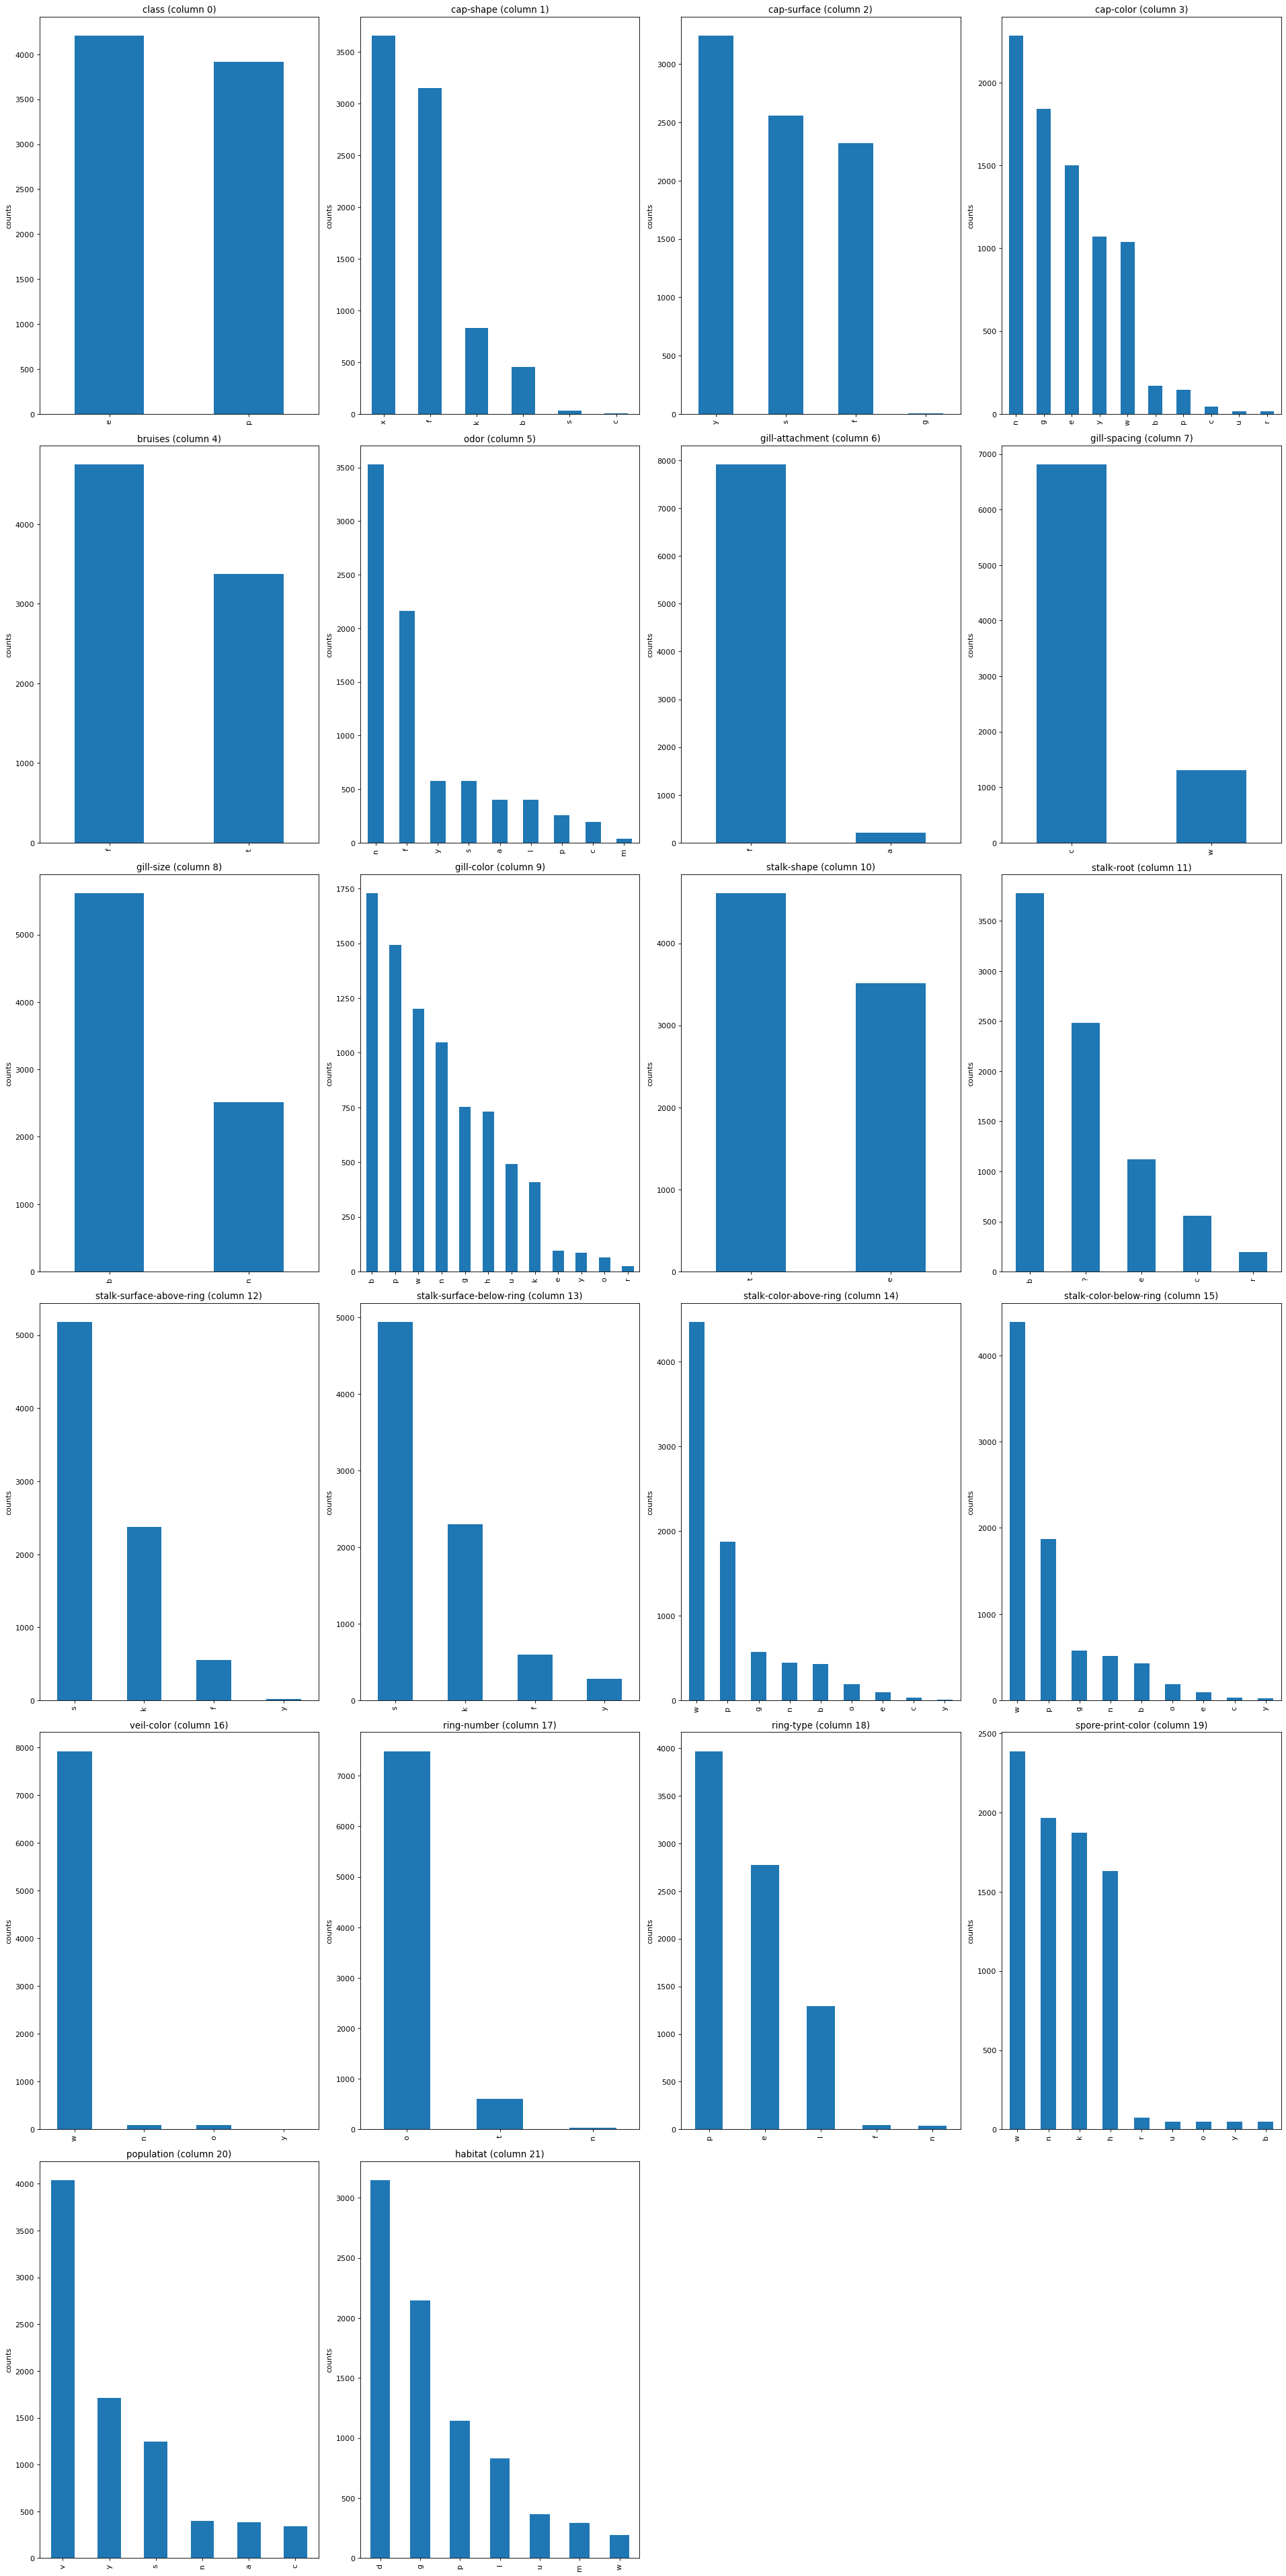

In [6]:
plotPerColumnDistribution(shrooms, 24, 4)

### Split into train and test

In [31]:
# shuffle shrooms
shrooms = shrooms.sample(frac=1, random_state=421)
y, x = shrooms.iloc[:, 0], shrooms.iloc[:, 1:]

In [32]:
def convert_to_tensors(x, y, encode=False):
    class_map = {'p': 1, 'e': 0}
    Y = torch.tensor(y.map(class_map).values)
    
    n_features = x.shape[1]
    n_examples = x.shape[0]
    
    X = np.zeros((n_examples, n_features))
    for i in range(n_features):
        col = x.iloc[:,i]
        X[:, i] = col.map({k:v for k,v in zip(col.unique(), range(col.nunique()))})
    X = torch.tensor(X)
    if encode:
        return F.one_hot(X.long()), Y
    else:
        return X.long(), Y

In [33]:
X, Y = convert_to_tensors(x, y)
frac_train = 0.8
n = int(frac_train*len(shrooms))

Xtr, Ytr = X[:n], Y[:n]
Xtest, Ytest = X[n:], Y[n:]

In [34]:
n_features = Xtr.shape[1]

### Initialize the parameters for the MLP

In [35]:
NUM_NEURONS = 10
g = torch.Generator().manual_seed(13)

# embedding
def emb_dimensionality(cat_cardinality):
    return min( 600, round(1.6 * cat_cardinality**0.56) )
embs = [ torch.randn(i:=shrooms[c].nunique(), emb_dimensionality(i), generator=g) for c in shrooms.iloc[:, 1:].columns ]
tot_emb_dim = sum(e.shape[1] for e in embs)

# first layer
W1 = torch.randn((tot_emb_dim, NUM_NEURONS), generator=g) / (tot_emb_dim)**0.5
b1 = torch.randn(NUM_NEURONS, generator=g) * 0.01

# output layer
W2 = torch.randn((NUM_NEURONS, ), generator=g) / (NUM_NEURONS)**0.5
b2 = torch.randn(1, generator=g) * 0

parameters = embs + [W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [36]:
sum(p.nelement() for p in parameters)

1335

In [37]:
BATCH_SIZE = 32

In [38]:
@torch.no_grad()
def evaluate_split(split, prnt=True):
    x, y = {'training': (Xtr, Ytr),
            'test': (Xtest, Ytest)}[split]
    
    emb_list = []
    for iF in range(n_features):
        emb_list.append(embs[iF][x[:, iF]])
        
    h = (torch.concat(emb_list,dim=1) @ W1 + b1).relu()
    logits = h @ W2 + b2
    sig = logits.sigmoid()
    loss = F.binary_cross_entropy(sig, y.float())
    if prnt:
        print(f'{split} loss: {loss.item()}')
    return loss.item()
    
evaluate_split('training');
evaluate_split('test');

training loss: 0.6429400444030762
test loss: 0.6356428861618042


### tune learning rate

In [150]:
N_EPOCHS = 1000
PRINT_EVERY = 1200
learning_rates = torch.logspace(-4, 0, N_EPOCHS)

losses = []
for iEpoch in range(N_EPOCHS):
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix].float()
    
    emb_list = []
    for iF in range(n_features):
        emb_list.append(embs[iF][Xb[:, iF]])
    
    h = (torch.concat(emb_list,dim=1) @ W1 + b1).tanh()

    logits = h @ W2 + b2
    sig = logits.sigmoid()
    loss = F.binary_cross_entropy(sig, Yb)
    for p in parameters:
        p.grad = None
        # p.register_hook(lambda grad: torch.clamp(grad, -CLIP_VALUE, CLIP_VALUE))
    
    loss.backward()
    for p in parameters[1:]:
        p.data += -learning_rates[iEpoch] * p.grad
    
    losses.append(loss.item())
    # track stats:
    if iEpoch % PRINT_EVERY == 0:
        print(f'{iEpoch:7d}/{N_EPOCHS}: {loss.item()}')
        # evaluate_split('test')
    # if iEpoch == 451:
print(loss.item())

      0/1000: 0.7033354043960571
0.0018641285132616758


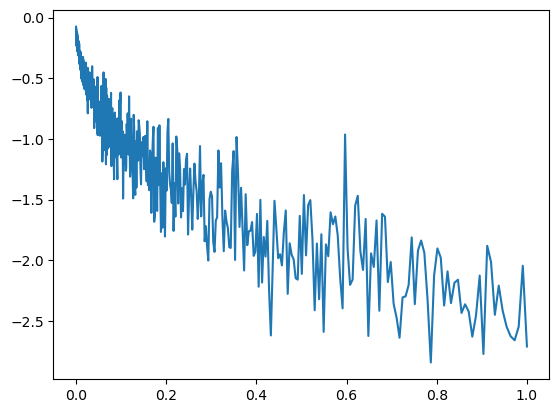

In [76]:
plt.plot(learning_rates, torch.tensor(losses).log10())

### Monitor the loss to see if we're overfitting

In [100]:
N_EPOCHS = 10_000
PRINT_EVERY = 1000
learning_rate = 0.01

tlosses = []
losses = []
trlosses = []
for iEpoch in range(N_EPOCHS):
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix].float()
    
    emb_list = []
    for iF in range(n_features):
        emb_list.append(embs[iF][Xb[:, iF]])
    
    h = (torch.concat(emb_list,dim=1) @ W1 + b1).relu()

    logits = h @ W2 + b2
    sig = logits.sigmoid()
    loss = F.binary_cross_entropy(sig, Yb)
    for p in parameters:
        p.grad = None
        # p.register_hook(lambda grad: torch.clamp(grad, -CLIP_VALUE, CLIP_VALUE))
    
    loss.backward()
    for p in parameters:
        p.data += -learning_rate * p.grad
    
    losses.append(loss.item())
    # track stats:
    if iEpoch % PRINT_EVERY == 0:
        print(f'{iEpoch:7d}/{N_EPOCHS}: {loss.item()}')
        tlosses.append(evaluate_split('test', prnt=False))
        trlosses.append(evaluate_split('training', prnt=False))
    # if iEpoch == 451:
print(loss.item())

      0/10000: 0.7931904792785645
   1000/10000: 0.07351026684045792
   2000/10000: 0.04689661040902138
   3000/10000: 0.011831284500658512
   4000/10000: 0.010844157077372074
   5000/10000: 0.010465606115758419
   6000/10000: 0.00959165021777153
   7000/10000: 0.010175704956054688
   8000/10000: 0.002597126644104719
   9000/10000: 0.007662598043680191
0.002276527928188443


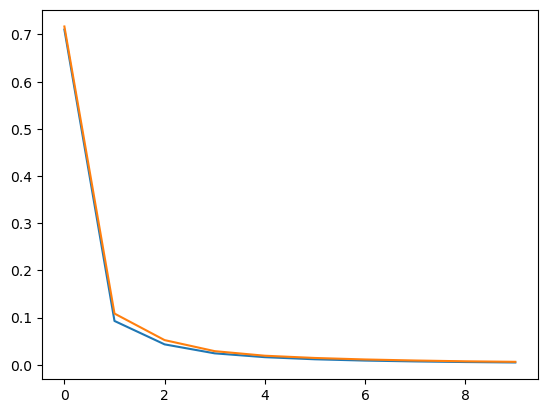

In [101]:
plt.plot(torch.arange(len(trlosses)), trlosses)
plt.plot(torch.arange(len(tlosses)), tlosses)

### Train for 20000 epochs

In [39]:
N_EPOCHS = 20_000
learning_rate = 0.01

for iEpoch in range(N_EPOCHS):
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix].float()
    
    emb_list = []
    for iF in range(n_features):
        emb_list.append(embs[iF][Xb[:, iF]])
    
    h = (torch.concat(emb_list,dim=1) @ W1 + b1).relu()

    logits = h @ W2 + b2
    sig = logits.sigmoid()
    loss = F.binary_cross_entropy(sig, Yb)
    for p in parameters:
        p.grad = None
        # p.register_hook(lambda grad: torch.clamp(grad, -CLIP_VALUE, CLIP_VALUE))
    
    loss.backward()
    for p in parameters:
        p.data += -learning_rate * p.grad
        
print(loss.item())

0.0024449010379612446


### Evaluate network

In [40]:
emb_list = []
for iF in range(n_features):
    emb_list.append(embs[iF][Xtest[:, iF]])

h = (torch.concat(emb_list,dim=1) @ W1 + b1).relu()

logits = h @ W2 + b2
sig = logits.sigmoid()

In [41]:
edible_threshold = 0.5
predictions = [1 if p > edible_threshold else 0 for p in sig]

In [42]:
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix

cf_matrix = confusion_matrix(Ytest, predictions)
print(cf_matrix)

[[835   0]
 [  0 790]]


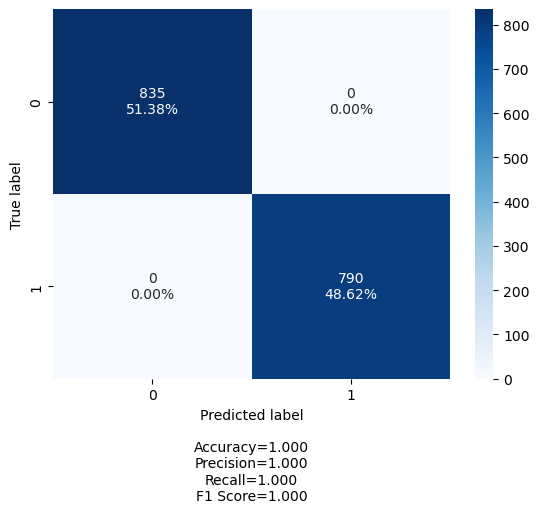

In [43]:
make_confusion_matrix(cf_matrix)

# scikit-learn logistic regression

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix

data = pd.read_csv("mushrooms.csv")

In [159]:
labelencoder=LabelEncoder()
for col in data.columns:
    data[col] = labelencoder.fit_transform(data[col])

In [160]:
X = data.iloc[:,1:23]  # all rows, all the features and no labels
y = data.iloc[:, 0]  # all rows, label only

In [161]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

model_LR = LogisticRegression()

In [163]:
model_LR.fit(X_train, y_train);

In [164]:
y_prob = model_LR.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model_LR.score(X_test, y_pred)

1.0

In [165]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[815  30]
 [ 36 744]]


In [166]:
auc_roc=metrics.roc_auc_score(y_test,y_pred)
auc_roc

0.9591715976331362

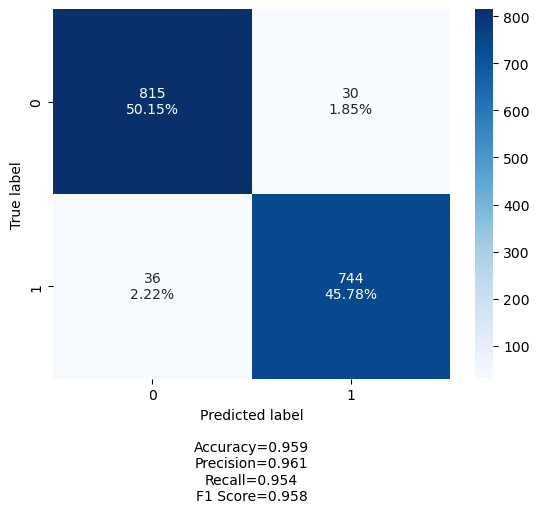

In [167]:
make_confusion_matrix(cf_matrix)

# Scikit-learn random forest

In [22]:
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from cf_matrix import make_confusion_matrix

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # plotting
import os # accessing directory structure

In [23]:
shrooms = pd.read_csv('mushrooms.csv')

In [24]:
labelencoder=LabelEncoder()
data = pd.DataFrame()
for col in shrooms.columns:
    data[col] = labelencoder.fit_transform(shrooms[col])

X = data.iloc[:,1:23]  # all rows, all the features and no labels
y = data.iloc[:, 0]  # all rows, label only

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [26]:
clf = RandomForestClassifier(random_state=123)
clf.fit(X_train, y_train)
 
# Predict on training set
pred_y = clf.predict(X_test)
 
# How's our accuracy?
print( accuracy_score(y_test, pred_y) )
 
# What about AUROC?
prob_y = clf.predict_proba(X_test)
prob_y = [p[1] for p in prob_y]
print( roc_auc_score(y_test, prob_y) )

1.0
1.0


In [27]:
edible_threshold = 0.5
predictions = [1 if p > edible_threshold else 0 for p in prob_y]

In [29]:
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)

[[845   0]
 [  0 780]]


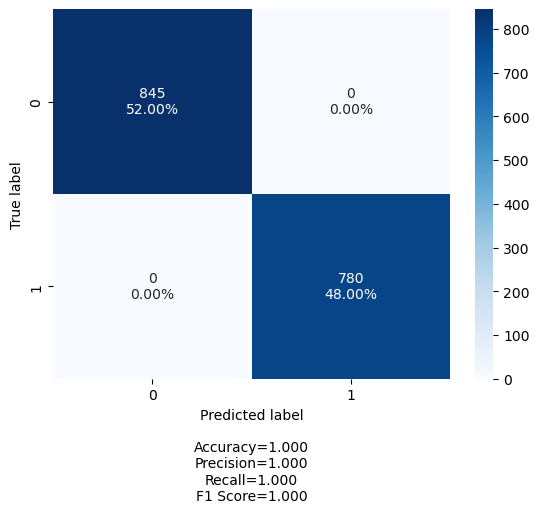

In [30]:
make_confusion_matrix(cf_matrix)